# MovieLens ML-1m EDA

## Setup

In [ ]:
import os
project_name = "chef-recsys"; branch = "main"; account = "sparsh-ai"
project_path = os.path.join('/content', branch)

if not os.path.exists(project_path):
    !cp -r /content/drive/MyDrive/git_credentials/. ~
    !mkdir "{project_path}"
    %cd "{project_path}"
    !git init
    !git remote add origin https://github.com/"{account}"/"{project_name}".git
    !git pull origin "{branch}"
    !git checkout -b "{branch}"
else:
    %cd "{project_path}"

/content/main
Initialized empty Git repository in /content/main/.git/
remote: Enumerating objects: 4, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 4 (delta 0), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (4/4), done.
From https://github.com/sparsh-ai/chef-recsys
 * branch            main       -> FETCH_HEAD
 * [new branch]      main       -> origin/main
Switched to a new branch 'main'


In [ ]:
!cd /content/main && git add . && git commit -m 'commit' && git push origin main

[main 14b73a1] commit
 3 files changed, 0 insertions(+), 0 deletions(-)
 create mode 100644 T590975/data/movies.parquet.snappy
 create mode 100644 T590975/data/ratings.parquet.snappy
 create mode 100644 T590975/data/ratings_cleaned.parquet.snappy
Counting objects: 7, done.
Delta compression using up to 2 threads.
Compressing objects: 100% (6/6), done.
Writing objects: 100% (7/7), 29.89 MiB | 10.14 MiB/s, done.
Total 7 (delta 0), reused 0 (delta 0)
To https://github.com/sparsh-ai/chef-recsys.git
   b5ee171..14b73a1  main -> main


In [ ]:
%cd /content

/content


In [ ]:
!pip install tensorflow_recommenders
!pip install folium

In [ ]:
import os
import pprint
import tempfile
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, Text
from wordcloud import WordCloud
import requests
import folium
from folium.plugins import MarkerCluster

import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from typing import Dict, Text
import pandas as pd
import numpy as np

import tensorflow as tf

import tensorflow_datasets as tfds
import tensorflow_recommenders as tfrs

plt.style.use('ggplot')

In [ ]:
import warnings
warnings.filterwarnings('ignore')

## Data Loading

Note that since the MovieLens dataset does not have predefined splits, all data are under train split.

In [ ]:
# Ratings data.
ratings = tfds.load("movielens/1m-ratings", split="train", shuffle_files=True)
# Features of all the available movies.
movies = tfds.load("movielens/1m-movies", split="train", shuffle_files=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/movielens/1m-ratings/0.1.0.incompleteDLG3X1/movielens-train.tfrecord


  0%|          | 0/1000209 [00:00<?, ? examples/s]

Dataset movielens downloaded and prepared to /root/tensorflow_datasets/movielens/1m-ratings/0.1.0. Subsequent calls will reuse this data.


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/movielens/1m-movies/0.1.0.incompleteHECP6W/movielens-train.tfrecord


  0%|          | 0/3883 [00:00<?, ? examples/s]

Dataset movielens downloaded and prepared to /root/tensorflow_datasets/movielens/1m-movies/0.1.0. Subsequent calls will reuse this data.


The ratings dataset returns a dictionary of movie id, user id, the assigned rating, timestamp, movie information, and user information:

In [ ]:
#View the data from ratings dataset:
for x in ratings.take(1).as_numpy_iterator():
    pprint.pprint(x)

{'bucketized_user_age': 35.0,
 'movie_genres': array([ 1,  3, 14]),
 'movie_id': b'362',
 'movie_title': b'Jungle Book, The (1994)',
 'timestamp': 965278460,
 'user_gender': True,
 'user_id': b'4285',
 'user_occupation_label': 11,
 'user_occupation_text': b'other/not specified',
 'user_rating': 4.0,
 'user_zip_code': b'62704'}


The movies dataset contains the movie id, movie title, and data on what genres it belongs to. Note that the genres are encoded with integer labels:

In [ ]:
#View the data from movies dataset:
for x in movies.take(1).as_numpy_iterator():
    pprint.pprint(x)

{'movie_genres': array([5, 7]),
 'movie_id': b'1729',
 'movie_title': b'Jackie Brown (1997)'}


Now let's convert Tensforflow Dataset into a Pandas Data Frame:

In [ ]:
# df = tfds.as_dataframe(ratings.take(10000)) # Use This line if you want to limit the conversion into small Pandas DataFrame
df = tfds.as_dataframe(ratings)
df1 = tfds.as_dataframe(movies)

In [ ]:
df.head()

,bucketized_user_age,movie_genres,movie_id,movie_title,timestamp,user_gender,user_id,user_occupation_label,user_occupation_text,user_rating,user_zip_code
0,45.0,"[5, 16]",b'2391',"b'Simple Plan, A (1998)'",967497374,False,b'3483',6,b'executive/managerial',4.0,b'30260'
1,25.0,[7],b'1203',b'12 Angry Men (1957)',1015736614,True,b'3475',14,b'sales/marketing',3.0,b'33133'
2,25.0,"[3, 4]",b'586',b'Home Alone (1990)',975897100,True,b'595',6,b'executive/managerial',4.0,b'10019'
3,35.0,"[0, 1, 4, 14]",b'1197',"b'Princess Bride, The (1987)'",972790580,False,b'2804',11,b'other/not specified',5.0,b'46234'
4,25.0,"[4, 14]",b'2502',b'Office Space (1999)',974757114,True,b'1457',0,b'academic/educator',4.0,b'95472'


In [ ]:
df.shape

(1000209, 11)

In [ ]:
df.info()

<class 'tensorflow_datasets.core.as_dataframe.StyledDataFrame'>
RangeIndex: 1000209 entries, 0 to 1000208
Data columns (total 11 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   bucketized_user_age    1000209 non-null  float64
 1   movie_genres           1000209 non-null  object 
 2   movie_id               1000209 non-null  object 
 3   movie_title            1000209 non-null  object 
 4   timestamp              1000209 non-null  int64  
 5   user_gender            1000209 non-null  bool   
 6   user_id                1000209 non-null  object 
 7   user_occupation_label  1000209 non-null  int64  
 8   user_occupation_text   1000209 non-null  object 
 9   user_rating            1000209 non-null  float64
 10  user_zip_code          1000209 non-null  object 
dtypes: bool(1), float64(2), int64(2), object(6)
memory usage: 77.3+ MB


In [ ]:
df.describe()

,bucketized_user_age,timestamp,user_occupation_label,user_rating
count,1.000209e+06,1.000209e+06,1.000209e+06,1.000209e+06
mean,2.973831e+01,9.722437e+08,1.105189e+01,3.581564e+00
std,1.175198e+01,1.215256e+07,6.571510e+00,1.117102e+00
min,1.000000e+00,9.567039e+08,0.000000e+00,1.000000e+00
25%,2.500000e+01,9.653026e+08,6.000000e+00,3.000000e+00
50%,2.500000e+01,9.730180e+08,1.200000e+01,4.000000e+00
75%,3.500000e+01,9.752209e+08,1.700000e+01,4.000000e+00
max,5.600000e+01,1.046455e+09,2.100000e+01,5.000000e+00


In [ ]:
df.to_parquet('ratings.parquet.snappy', compression='snappy')
df1.to_parquet('movies.parquet.snappy', compression='snappy')

In [ ]:
!mkdir -p main/T590975/data
!cp ratings.parquet.snappy main/T590975/data
!cp movies.parquet.snappy main/T590975/data

## Data Wrangling

**Data Wrangling Objective:**

 * Let's change user_gender from boolian Female or Male: True --> Male, False --> Female
 * Let's remove the symbols: (b), (') and (").
 * Let's drop columns: user_occupation_label and movie_genres.
 * Let's change "timestamp" which is in the unix epoch (units of seconds) to datetime64[ns]
 * Let's fix any wrong values in user_zip_code (Any zipcode >5 characters)

In [ ]:
ratings_1 = pd.read_parquet('ratings.parquet.snappy')

In [ ]:
# let's Change user_gender from boolian Female or Male: True --> Male, False --> Female:
ratings_1.loc[ratings_1['user_gender'] == True, 'user_gender'] = 'm'
ratings_1.loc[ratings_1['user_gender'] == False, 'user_gender'] = 'f'

# Now let's remove (b) and ('')
# Normal method .str.strip wont't work because it doesn't recognize it as a string column and it will raise an error. 
# So, let's force the columns to string dtype using .apply(str) as shown below:
ratings_1['user_zip_code'] = ratings_1['user_zip_code'].astype('str').str.strip("b")
ratings_1['user_zip_code'] = ratings_1['user_zip_code'].astype('str').str.strip("'")

# Ok, Now let's looks at user_zip_code (Any zipcode >5 characters):
ratings_1[ratings_1.user_zip_code.str.len() ==10]
# for all user_zip_code  >5 characters, let's only keep the first 5 characters:
ratings_1['user_zip_code'] = ratings_1['user_zip_code'].str[:5]
# Let's confirm that all user_zip_code are 5 characters or less:
ratings_1[ratings_1.user_zip_code.str.len() ==10]
# Let's change now user_zip_code data type from str to int:
ratings_1['user_zip_code'] = ratings_1['user_zip_code'].astype('int64')

# Now let's remove (b), (') and (") from 'user_occupation_text', 'user_id', 'movie_title' and 'movie_id'
ratings_1['user_occupation_text'] = ratings_1['user_occupation_text'].astype('str').str.strip("b")
ratings_1['user_occupation_text'] = ratings_1['user_occupation_text'].astype('str').str.strip("'")
ratings_1['user_id'] = ratings_1['user_id'].astype('str').str.strip("b")
ratings_1['user_id'] = ratings_1['user_id'].astype('str').str.strip("'")
ratings_1['movie_title'] = ratings_1['movie_title'].astype('str').str.strip("b")
ratings_1['movie_title'] = ratings_1['movie_title'].astype('str').str.strip("'")
ratings_1['movie_title'] = ratings_1['movie_title'].astype('str').str.strip('"')
ratings_1['movie_id'] = ratings_1['movie_id'].astype('str').str.strip("b")
ratings_1['movie_id'] = ratings_1['movie_id'].astype('str').str.strip("'")

# Let's change the datatype of 'user_id' and 'movie_id' from str to int:
ratings_1['user_id'] = ratings_1['user_id'].astype('int64')
ratings_1['movie_id'] = ratings_1['movie_id'].astype('int64')

# Let's extract the release year from title:
ratings_1['movie_release_year'] = ratings_1['movie_title'].str[-5:-1]
ratings_1['movie_release_year'] = pd.to_datetime(ratings_1['movie_release_year'])

# Finally, let's change "timestamp" which is in the unix epoch (units of seconds) to datetime64[ns]:
ratings_1['timestamp'] = pd.to_datetime(ratings_1['timestamp'], unit = 's')

In [ ]:
ratings_1.head()

,bucketized_user_age,movie_genres,movie_id,movie_title,timestamp,user_gender,user_id,user_occupation_label,user_occupation_text,user_rating,user_zip_code,movie_release_year
0,45.0,"[5, 16]",2391,"Simple Plan, A (1998)",2000-08-28 21:16:14,f,3483,6,executive/managerial,4.0,30260,1998-01-01
1,25.0,[7],1203,12 Angry Men (1957),2002-03-10 05:03:34,m,3475,14,sales/marketing,3.0,33133,1957-01-01
2,25.0,"[3, 4]",586,Home Alone (1990),2000-12-04 02:31:40,m,595,6,executive/managerial,4.0,10019,1990-01-01
3,35.0,"[0, 1, 4, 14]",1197,"Princess Bride, The (1987)",2000-10-29 03:36:20,f,2804,11,other/not specified,5.0,46234,1987-01-01
4,25.0,"[4, 14]",2502,Office Space (1999),2000-11-20 21:51:54,m,1457,0,academic/educator,4.0,95472,1999-01-01


In [ ]:
ratings_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000209 entries, 0 to 1000208
Data columns (total 12 columns):
 #   Column                 Non-Null Count    Dtype         
---  ------                 --------------    -----         
 0   bucketized_user_age    1000209 non-null  float64       
 1   movie_genres           1000209 non-null  object        
 2   movie_id               1000209 non-null  int64         
 3   movie_title            1000209 non-null  object        
 4   timestamp              1000209 non-null  datetime64[ns]
 5   user_gender            1000209 non-null  object        
 6   user_id                1000209 non-null  int64         
 7   user_occupation_label  1000209 non-null  int64         
 8   user_occupation_text   1000209 non-null  object        
 9   user_rating            1000209 non-null  float64       
 10  user_zip_code          1000209 non-null  int64         
 11  movie_release_year     1000209 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float6

In [ ]:
pd.set_option('float_format', '{:.1f}'.format)
ratings_1.describe()

,bucketized_user_age,movie_id,user_id,user_occupation_label,user_rating,user_zip_code
count,1000209.0,1000209.0,1000209.0,1000209.0,1000209.0,1000209.0
mean,29.7,1865.5,3024.5,11.1,3.6,54230.9
std,11.8,1096.0,1728.4,6.6,1.1,32090.6
min,1.0,1.0,1.0,0.0,1.0,231.0
25%,25.0,1030.0,1506.0,6.0,3.0,23185.0
50%,25.0,1835.0,3070.0,12.0,4.0,55129.0
75%,35.0,2770.0,4476.0,17.0,4.0,90004.0
max,56.0,3952.0,6040.0,21.0,5.0,99945.0


In [ ]:
ratings_1.to_parquet('ratings_cleaned.parquet.snappy', compression='snappy')

In [ ]:
!cp ratings_cleaned.parquet.snappy main/T590975/data

**Awesome, There's no missing values :)**

**Alright, As you can see above, we managed to:**

 * Change 'user_gender' from boolian Female or Male: True --> Male, False --> Female.
 * Remove all special characters from all features: (b) and (').
 * Correct 'user_zip_code' to keep only 5 Characters for each.
 * Change datatype to reflect the data.
 * Change "timestamp" which is in the unix epoch (units of seconds) to datetime64[ns].
 * No missing values.
    

## EDA

**Alright, let's start the fun part, let's extract insights from the dataset by asking very useful questions:**

- What is the preferable month of the year to rate/watch movies?
- What is the preferable day of the week to rate/watch movies?
- Who watches/rates more movies Men/Women?
- What age group watches more movies?
- Which kind of occupant watches/rates more movies?
- How much rating people give mostly? distributed between gendors?
- What are the most rated movies?
- What are the most loved Movies?
- Which year the users were interested the most to rate/watch movies?
- What are the worst movies per rating? Using worldcloud Package

In [ ]:
df = pd.read_parquet('ratings_cleaned.parquet.snappy')

**What is the preferable month of the year to rate/watch movies?**

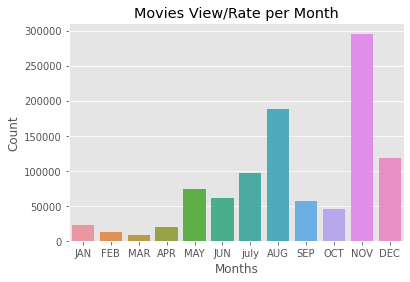

In [ ]:
plt.figure(figsize=(6,4))
movies_view_habit = df.groupby(df.timestamp.dt.month).size()
sns.barplot(['JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'july', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC'], movies_view_habit.values)
plt.title('Movies View/Rate per Month');
plt.xlabel('Months')
plt.ylabel('Count')
plt.show()

Ok, Summer & Holidays Months are the highest, which make sense!!!

**What is the preferable day of the week to rate/watch movies?**

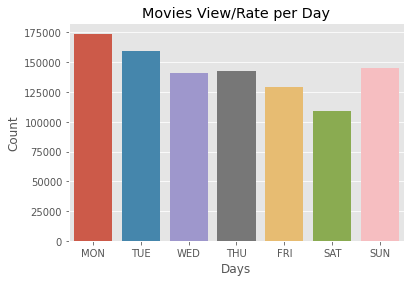

In [ ]:
plt.figure(figsize=(6,4))
movies_view_daily = df.groupby(df.timestamp.dt.dayofweek).size()
sns.barplot(['MON', 'TUE', 'WED', 'THU', 'FRI', 'SAT', 'SUN'], movies_view_daily.values);
plt.title('Movies View/Rate per Day');
plt.xlabel('Days');
plt.ylabel('Count')
plt.show()

As shown above, looks like people enjoys watching/rating movies during weekdays and probably going out for a theater during the weekend (low rating/watching). Or MovieLens team asked users to rate movies in their workdays.

**Who watches/rates more movies Men/Women?**

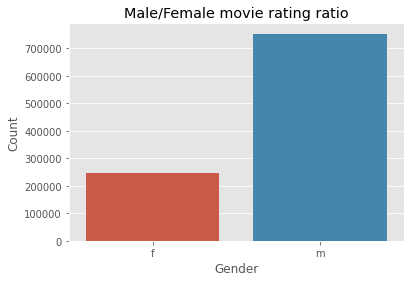

In [ ]:
plt.figure(figsize=(6,4))
sns.barplot(df.groupby('user_gender').size().index, df.groupby('user_gender').size().values)
plt.title('Male/Female movie rating ratio')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

Males look like are more interesting in rating movies than females!!

**What age group watches more movies?**

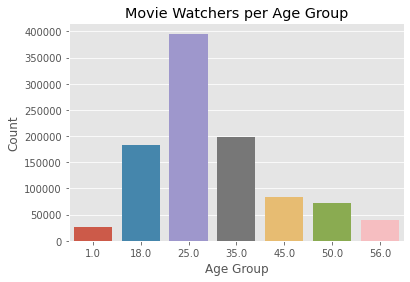

In [ ]:
plt.figure(figsize=(6,4))
sns.barplot(df.groupby('bucketized_user_age').size().index, df.groupby('bucketized_user_age').size().values)
plt.title('Movie Watchers per Age Group');
plt.xlabel('Age Group');
plt.ylabel('Count')
plt.show()

As shown above, users aged between 18 to 34 are most who watch or rate Movies.

**Which kind of occupant watches/rates more movies?**

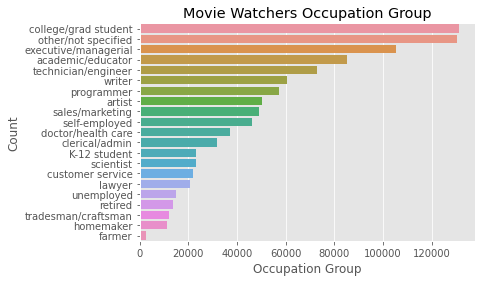

In [ ]:
plt.figure(figsize=(6,4))
movie_watcher_occupants = df.groupby('user_occupation_text').size().sort_values(ascending=False)
sns.barplot(y=movie_watcher_occupants.index, x=movie_watcher_occupants.values)
plt.title('Movie Watchers Occupation Group')
plt.xlabel('Occupation Group')
# plt.xticks(rotation=90);
plt.ylabel('Count')
plt.show()

**How much rating people give mostly? distributed between gendors?**

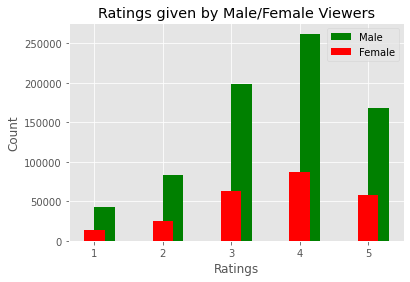

In [ ]:
temp_df = df.groupby(['user_gender', 'user_rating']).size()
plt.figure(figsize=(6, 4))
m_temp_df = temp_df.m.sort_values(ascending=False)
f_temp_df = temp_df.f.sort_values(ascending=False)

plt.bar(x=m_temp_df.index, height=m_temp_df.values, label="Male", align="edge", width=0.3, color='green')
plt.bar(x=f_temp_df.index, height=f_temp_df.values, label="Female", width=0.3, color='red')
plt.title('Ratings given by Male/Female Viewers')
plt.legend()
plt.xlabel('Ratings')
plt.ylabel('Count')
plt.show()

Ok, That's interesting both males and females have shown the same trend in ratings and both have geven 4 as the highest ratings!!!

**What are the most rated movies? In terms of: All Time/Gender Group/Age Group?**

In [ ]:
def draw_horizontal_movie_bar(movie_titles, ratings_count, title=''):
    plt.figure(figsize=(6, 4))
    sns.barplot(y=movie_titles, x=ratings_count, orient='h')
    plt.title(title)
    plt.ylabel('Movies')
    plt.xlabel('Count')
    plt.show()

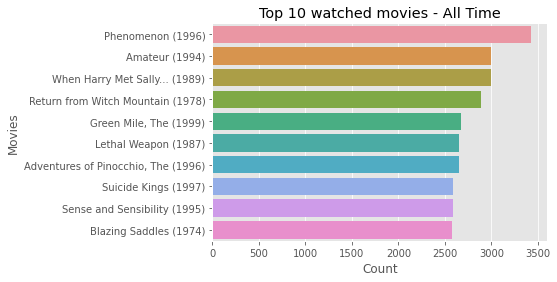

In [ ]:
top_ten_rated_movies = df.groupby('movie_id').size().sort_values(ascending=False)[:10]
top_ten_movie_titles = df.iloc[top_ten_rated_movies.index].movie_title

draw_horizontal_movie_bar(top_ten_movie_titles.values, top_ten_rated_movies.values, 'Top 10 watched movies - All Time')

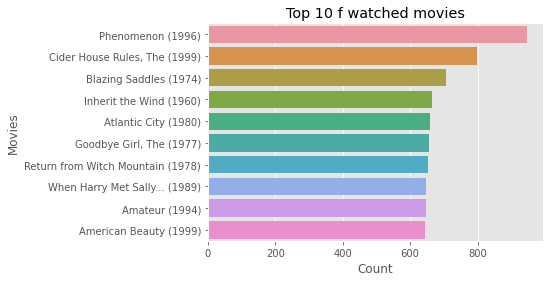

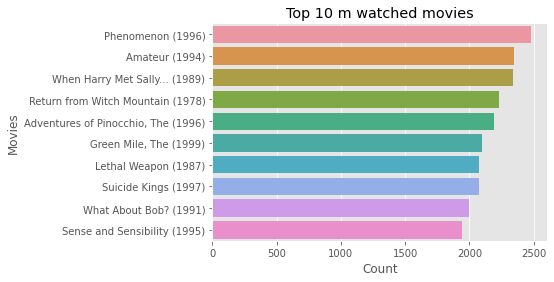

In [ ]:
top_rated_movies_gender_wise = df.groupby(['user_gender','movie_id']).size()

for index_label in top_rated_movies_gender_wise.index.get_level_values(0).unique():

    top_10_userkind_rated_movies = top_rated_movies_gender_wise[index_label].sort_values(ascending=False)[:10]
    top_10_userkind_rated_movie_titles = df.iloc[top_10_userkind_rated_movies.index].movie_title
    draw_horizontal_movie_bar(top_10_userkind_rated_movie_titles.values, top_10_userkind_rated_movies.values, f'Top 10 {index_label} watched movies')

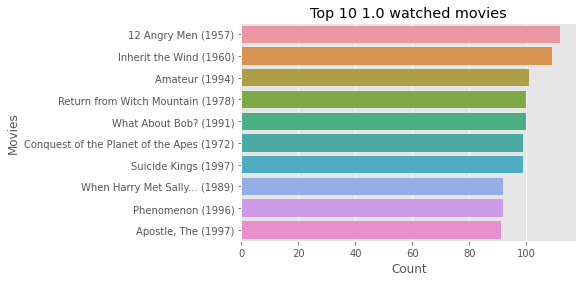

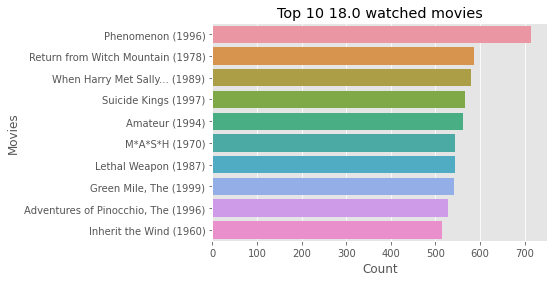

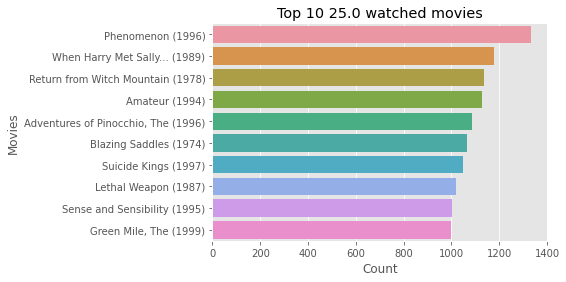

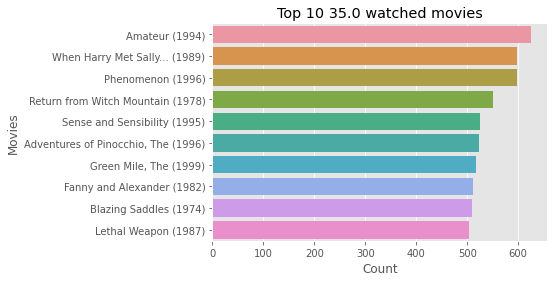

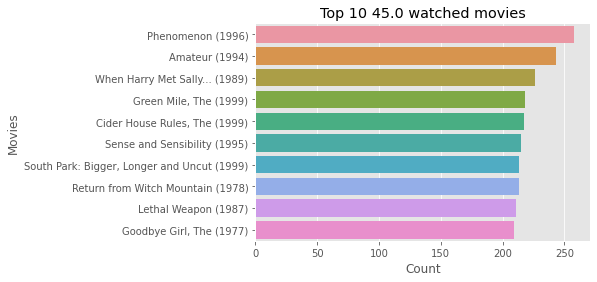

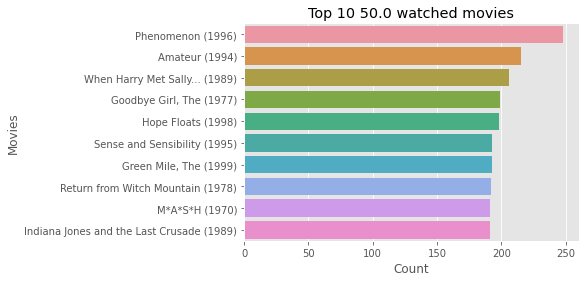

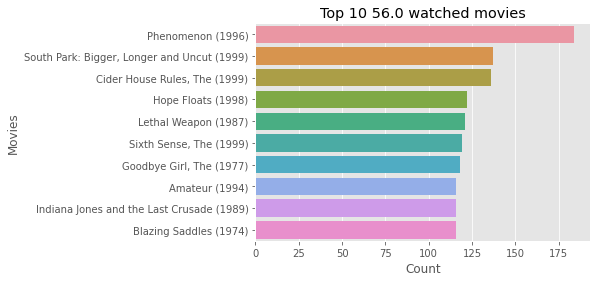

In [ ]:
top_rated_movies_age_group_wise = df.groupby(['bucketized_user_age','movie_id']).size()

for index_label in top_rated_movies_age_group_wise.index.get_level_values(0).unique():
    top_10_userkind_rated_movies = top_rated_movies_age_group_wise[index_label].sort_values(ascending=False)[:10]
    top_10_userkind_rated_movie_titles = df.iloc[top_10_userkind_rated_movies.index].movie_title
    draw_horizontal_movie_bar(top_10_userkind_rated_movie_titles.values, top_10_userkind_rated_movies.values, f'Top 10 {index_label} watched movies')

Now, let's create a new dataFrame so we can have only the unique movies to have more insights!!?

In [ ]:
# Create a dataframe called 'films':
films = df[['movie_title', 'movie_release_year']]
films.head()

,movie_title,movie_release_year
0,"Simple Plan, A (1998)",1998-01-01
1,12 Angry Men (1957),1957-01-01
2,Home Alone (1990),1990-01-01
3,"Princess Bride, The (1987)",1987-01-01
4,Office Space (1999),1999-01-01


In [ ]:
# Let's check how many unique movies we have:
films.movie_title.nunique()

3706

In [ ]:
# Let's sort the movies per 'movie_title':
films.sort_values("movie_title", inplace = True)

In [ ]:
# dropping ALL duplicate values:
films.drop_duplicates(subset ="movie_title", keep = 'first', inplace = True)

**Which year the users were interested the most to rate/watch movies?**

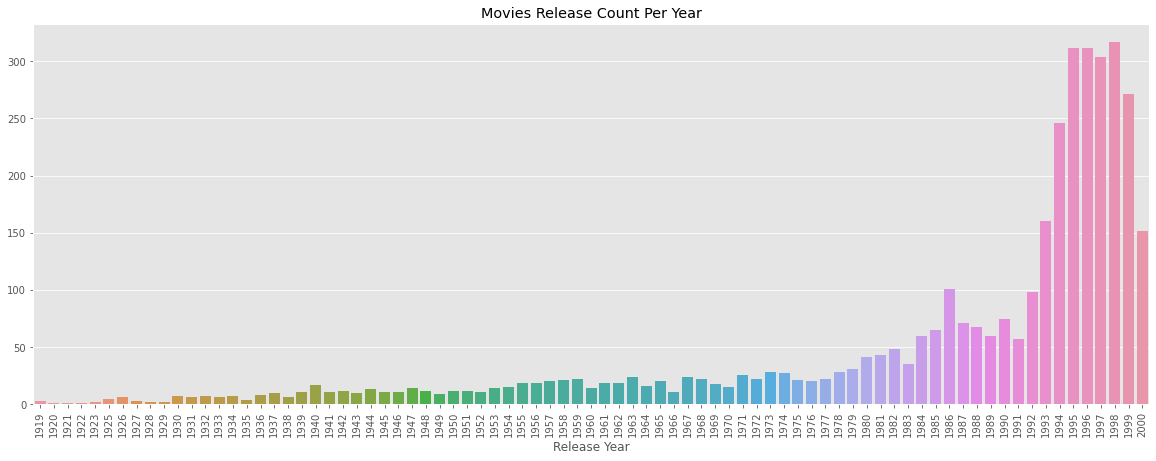

In [ ]:
plt.figure(figsize=(20,7))
yearly_release_counts = films.groupby(films.movie_release_year.dt.year).size().sort_values(ascending=False)
sns.barplot(yearly_release_counts.index, yearly_release_counts.values);
plt.xlabel('Release Year')
plt.xticks(rotation=90);
plt.title('Movies Release Count Per Year');

Alright, looks like our users were mainly interested in rating/watching the 90s Movies.

**What are the worst movies per rating?**

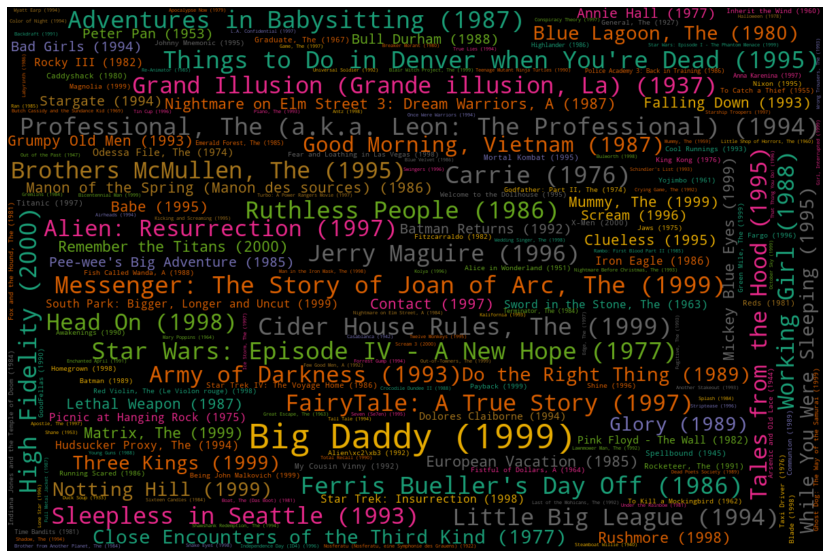

In [ ]:
movies_ratings_sum = df.groupby('movie_id').sum().user_rating.sort_values()
movies_ratings_sum.index = df.iloc[movies_ratings_sum.index].movie_title
# Will show movies with 0 < total_rating<= 10
lowest_rated_movies = movies_ratings_sum[movies_ratings_sum <= 10]


wordcloud = WordCloud(min_font_size=7, width=1200, height=800, random_state=21, max_font_size=50, relative_scaling=0.2, colormap='Dark2')
# Substracted lowest_rated_movies from 11 so that we can have greater font size of least rated movies.
wordcloud.generate_from_frequencies(frequencies=(11-lowest_rated_movies).to_dict())
plt.figure(figsize=(16,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()